## Thermal Sensitivity: Temperature Crossplot with Baseflow Separation

In [1]:
import os
from datetime import datetime, timezone, timedelta
from pprint import pprint

import numpy as np
import pandas as pd
from pandas.tseries.frequencies import to_offset
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [2]:
def get_frequency(idx):
    """Get the frequency string for a datetime index"""
    diffs = idx[1:] - idx[:-1]
    offset = to_offset(diffs.min())
    return offset.freqstr


def do_load(fn):
    """Load a parquet file with DateTimeIndex"""
    df = pd.read_parquet(fn)
    if df.index.freq is None:
        frequency = get_frequency(df.index)
        df = df.asfreq(frequency)
    return df


def do_runlength(df):
    """Label runs of consecutive days where baseflow = Q"""
    label = 0
    runlength = 0
    prev_state = False

    for ix, row in df.iterrows():
        state = row['is_baseflow']
        if state == prev_state:
            runlength += 1
        else:
            label += 1
            runlength = 1
        df.loc[ix, 'label'] = label
        df.loc[ix, 'runlength'] = runlength
        prev_state = state
        
    # get the duration of these recession periods
    periods = df.groupby('label').agg(
        firstday=('datetime', 'first'),
        lastday=('datetime', 'last'),
        is_baseflow=('is_baseflow','first'),
        runlength=('runlength','max')
    )
    return df, periods

***Edit here if You want a different year or season***

In [3]:
# - DateTime range -------------------------- #
year = 2024
season = 'Summer' # Summer/Winter/Wateryear

if season=='Winter':
    start_time = datetime(year-1, 12, 1, tzinfo=timezone(timedelta(hours=-5)))
    end_time = datetime(year, 2, 28, tzinfo=timezone(timedelta(hours=-5)))    
elif season=='Summer':
    start_time = datetime(year, 7, 1, tzinfo=timezone(timedelta(hours=-5)))
    end_time = datetime(year, 9, 30, tzinfo=timezone(timedelta(hours=-5)))
elif season=='Wateryear':
    start_time = datetime(year-1, 10, 1, tzinfo=timezone(timedelta(hours=-5)))
    end_time = datetime(year, 9, 30, tzinfo=timezone(timedelta(hours=-5)))
else:
    start_time = datetime(year, 1, 1, tzinfo=timezone(timedelta(hours=-5)))
    end_time = datetime(year, 12, 31, tzinfo=timezone(timedelta(hours=-5)))

***Edit here to specify the files to use***

In [4]:
# - Input and Output locations -------------------------- #
# Where save the output figures and stats
outdir = './output'

# streamgage timeseries
fn_gage="D:/dev/nb-sensors/data/dst/nwis_01480675_2023-01-01_2025-02-26.parquet"

# air temperature timeseries
fn_air = "D:/dev/nb-sensors/data/dst/pa_gm_20240914_hobo21852525_air.parquet"

# water temperature timeseries
fn_water = "D:/dev/nb-sensors/data/dst/pa_gm_20240914_hobo21852519_water.parquet"

# label for the water temperature hobo
hobo_name = 'GM-H19'

### Read the data 

In [5]:
# - Read the data -------------------------- #
# read the gage
df_gage = pd.read_parquet(fn_gage)
df_gage.index = df_gage.index.tz_convert('EST')
df_gage['datetime'] = df_gage.index

# read the air temperature, assign frequency and timezone to index
df_air = do_load(fn_air)
df_air = df_air.asfreq(freq="15min").tz_convert('EST')

# read the water temperature, assign frequency and timezone to index
df_water = pd.read_parquet(fn_water)
df_water=df_water.asfreq('15min').tz_convert('EST')

### Baseflow separation

This example uses pandas rolling statistics to pick minimum values within a moving window. Having baseflow we can create a boolean column "is_baseflow". Lastly we label and calculate the duration of baseflow periods. Other baseflow separation methods exist and I detail those here:

[https://github.com/mrahnis/nb-streamgage](https://github.com/mrahnis/nb-streamgage)

In [6]:
# - Baseflow calculation -------------------------- #
# baseflow separation using local minimum method
n = 3  # days
window = 2 * n * 24 * 60 / 15  # instantaneous window
df_gage["roll"] = (
    df_gage["00060"].shift(int(-(window - 1) / 2)).rolling(int(window)).min()
)
df_gage["baseflow"] = (
    df_gage["00060"].where(df_gage["00060"] == df_gage["roll"]).interpolate()
)
df_gage["is_baseflow"] = df_gage["baseflow"] + 1 >= df_gage["00060"]

# get information about the timing and length of baseflow periods
df_gage, periods = do_runlength(df_gage)
baseflow_periods = periods[periods['is_baseflow']==True]
baseflow_periods = baseflow_periods[baseflow_periods['firstday'].between(start_time, end_time, inclusive='left')]

### Make a timeseries plot

In [7]:
# Find the start and end times for our plot....
obs_start = np.minimum(df_water.index.min(), df_air.index.min())
obs_end = np.maximum(df_water.index.max(), df_air.index.max())
print(obs_start, obs_end)

2024-07-29 12:15:00-05:00 2024-09-14 13:30:00-05:00


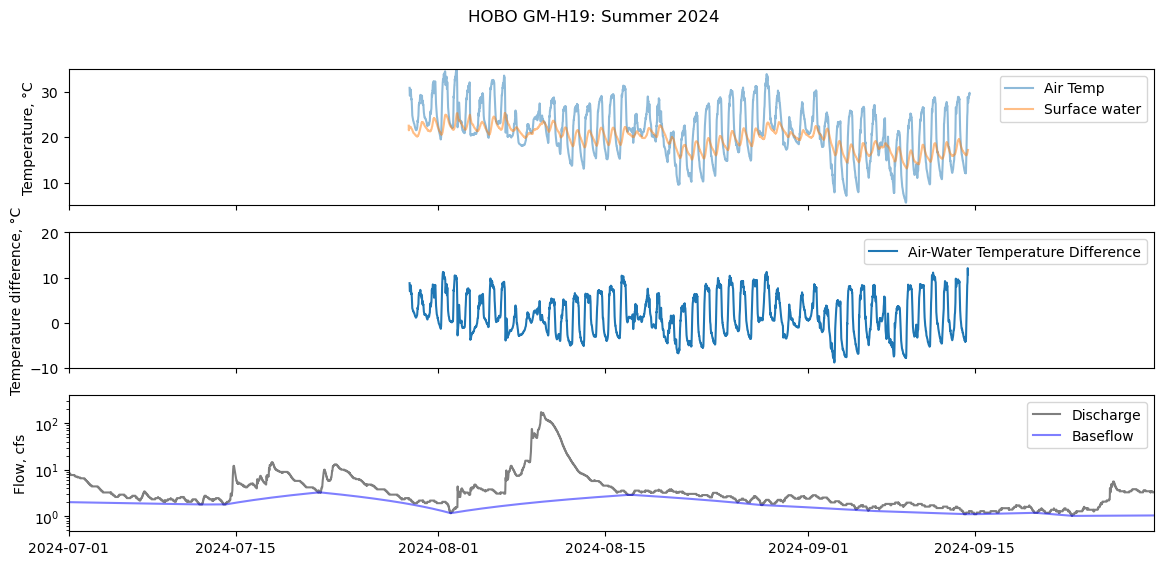

In [8]:
# - Timeseries Plots -------------------------- #
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
fig.set_size_inches(14, 6)

# observations subplot
ax1.set_xlim(start_time, end_time)
ax1.set_ylim(5, 35)
ax1.plot(df_air.index, df_air.Temp, alpha=0.5, label="Air Temp")
ax1.plot(df_water.index, df_water["Temp"].values, alpha=0.5, label="Surface water")
ax1.set_ylabel("Temperature, °C")
ax1.legend()

# difference subplot
diff = df_air["Temp"] - df_water["Temp"]
ax2.set_ylim(-10, 20)
ax2.plot(diff.index, diff.values, label='Air-Water Temperature Difference')
ax2.set_ylabel("Temperature difference, °C")
ax2.legend()

# discharge+baseflow subplot
ax3.plot(df_gage.index, df_gage["00060"].values, color="k", alpha=0.5, label='Discharge')
ax3.plot(df_gage.index, df_gage["baseflow"].values, color="blue", alpha=0.5, label='Baseflow')
ax3.set_yscale('log')
ax3.set_ylabel("Flow, cfs")
ax3.legend()

fig.suptitle(f"HOBO {hobo_name}: {season} {start_time.year}")

outfile = f'series-{start_time.year}-{season}-{hobo_name}.png'
# plt.savefig(f'{outdir}/{outfile}', dpi=300)

plt.show()

### Prepare the data

In [9]:
# - Slice series and prepare for model fitting -------------- #
flow_mask = df_gage[start_time:end_time].is_baseflow
flow_mask.name = "is_baseflow"

xs = df_air[start_time:end_time].Temp
xs.name = "air_temp"

ys = df_water["Temp"][start_time:end_time]
ys.name = "water_temp"

Xy = pd.concat([xs, ys, flow_mask], axis=1).tz_convert('EST')
Xy['minute_of_day'] = Xy.index.hour * 60 + Xy.index.minute

# drop records with missing values to satisfy the statistical models 
Xy.dropna(subset=["air_temp", "water_temp"], inplace=True)

obsmin = Xy[["air_temp", "water_temp"]].min().min()
obsmax = Xy[["air_temp", "water_temp"]].max().max()

# prepare the exogenous and endogenous variables 
X = (Xy["air_temp"].values)[:, np.newaxis]
y = Xy["water_temp"].values

### Fit the data

The first example here uses scikit-learn and the second uses statsmodels. There are a few differences to note:

- scikit-learn fit method takes the exog (x) variable as the first argument and the endog (y) variable as the second
- statsmodels fit method reverses the arguments, taking the endog first and the exog second
- statsmodels requires we add a constant to the exog variable in order to fit an intercept
- statsmodels reports more detailed statistics that help determine whether the model is an appropriate one

In [10]:
# - Fit the data using scikit-learn ----------------------#
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
reg = linear_model.LinearRegression()
reg.fit(X, y)
print(f"slope: {reg.coef_}, intercept: {reg.intercept_}")

# make predictions for some x-values so we can plot the regression
Xt = (np.linspace(obsmin, obsmax, 10))[:, np.newaxis]
yt_pred = reg.predict(Xt)

slope: [0.30653263], intercept: 13.154787374450358


In [11]:
# - Fit the data using statsmodels -----------------------#
# https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html
Xc = sm.add_constant(X)
results = sm.OLS(y, Xc).fit()
print(f"slope: {results.params[1]}, intercept: {results.params[0]}")

# write the results summary to a text file
outfile = f'{outdir}/stats-{start_time.year}-{season}-{hobo_name}.txt'
#with open(outfile, 'w') as fh:
#    fh.write(results.summary().as_text())

slope: 0.30653263306760187, intercept: 13.154787374450354


### Make two crossplots

The crossplot on the left is a regular crossplot with baseflow and quickflow/stormflow categories. The one on the right is a KDE (Kernel Density Estimation) plot that gives a sense of how hysteresis loops might influence our regression.

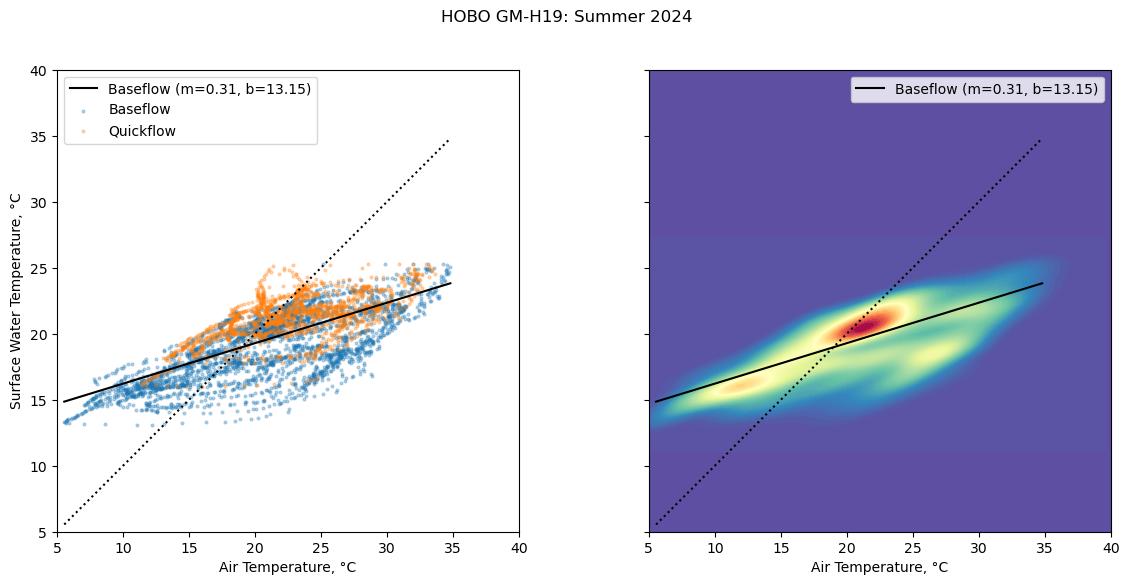

In [12]:
# - Plot Air-Water Cross plot ------------------------------------------- #
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(14, 6)

ax1.plot([obsmin, obsmax], [obsmin, obsmax], color="k", linestyle='dotted')
ax1.plot(Xt, yt_pred, color="k", label=f"Baseflow (m={reg.coef_[0]:.2f}, b={reg.intercept_:.2f})")
ax1.scatter(
    Xy["air_temp"].where(Xy["is_baseflow"] == True),
    Xy["water_temp"].where(Xy["is_baseflow"] == True),
    alpha=0.3,
    marker="o",
    s=4,
    label="Baseflow",
)
ax1.scatter(
    Xy["air_temp"].where(Xy["is_baseflow"] == False),
    Xy["water_temp"].where(Xy["is_baseflow"] == False),
    alpha=0.3,
    marker="o",
    s=4,
    label="Quickflow",
)
ax1.set_xlim(5, 40)
ax1.set_ylim(5, 40)
ax1.set_aspect("equal", "box")
ax1.set_xlabel("Air Temperature, °C")
ax1.set_ylabel("Surface Water Temperature, °C")
ax1.legend()

ax2.set_facecolor("#5e4fa2")
ax2.plot([obsmin, obsmax], [obsmin, obsmax], color="k", linestyle='dotted')
ax2.plot(Xt, yt_pred, color="k", label=f"Baseflow (m={reg.coef_[0]:.2f}, b={reg.intercept_:.2f})")
sns.kdeplot(
    data=Xy.where(Xy["is_baseflow"] == True),
    x="air_temp",
    y="water_temp",
    fill=True,
    thresh=0,
    levels=100,
    cmap="Spectral_r",
    hue_norm=colors.LogNorm(),
    ax=ax2,
)
ax2.set_aspect("equal", "box")
ax2.set_xlabel("Air Temperature, °C")
# ax2.set_ylabel('Surface Water Temperature, °C')
# ax2.set_ylabel(None)
ax2.legend()

fig.suptitle(f"HOBO {hobo_name}: {season} {start_time.year}")

outfile = f'xplot-{start_time.year}-{season}-{hobo_name}.png'
# plt.savefig(f'{outdir}/{outfile}', dpi=300)

plt.show()